# Банки — Сегментация пользователей по потреблению

Необходимо проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Ссылка на презентацию по проекту https://drive.google.com/file/d/1_aPJ2cKTR2Thu_csiZ3bGpJDpZVW8rDr/view?usp=sharing

## Обзор и предобработка данных

Импортируем необходимые библиотеки

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 


Ознакомимся с данными. 

In [55]:
try:
    df = pd.read_csv('bank_dataset.csv')    #загрузка файла по локальному пути
except:
    df = pd.read_csv('/datasets/bank_dataset.csv') #загрузка файла по серверному пути

df.head(10) # получение первых 10 строк таблицы

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Описание данных таблицы:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [56]:
df.info() # получение общей информации о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [57]:
df.duplicated().sum() # подсчет дубликатов

0

In [58]:
df.isna().sum() # подсчет пропущенных значений

userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

При изучении общей информации о данных видим, что в графе Balance присутствуют 3617 пропущенных значений, в остальных графах пропущенных значений нет. Полных дубликатов данные не содержат. Типы данных соответствуют. Заголовки необходимо привести к единому стилю.

In [59]:
df.columns # перечень названий столбцов таблицы df

Index(['userid', 'score', 'City', 'Gender', 'Age', 'Objects', 'Balance',
       'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn'],
      dtype='object')

In [60]:
df.columns = df.columns.str.lower()
df.columns # перечень названий столбцов после приведения к строчным буквам

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [61]:
df = df.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})
df.head() # получение первых 5 строк таблицы

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Проверим на неявные дубликаты столбцы с категориальными данными (city, gender) 

In [62]:
df['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [63]:
df['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

Видим что неявных дубликатов нет. А также что больше всего клиентов банка из Ярославля, между Ростовом Великим и Рыбинском разница в количестве клиентов небольшая. Среди клиентов больше мужчин, чем женщин на 914 человек. 

Посмотрим на основные характеристики данных

In [64]:
df.describe() 

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Видим что аномальных значений в данных нет. Данных о шкале для оценок кредитного скоринга у нас нет, поэтому оснований признать оценки от 350 до 850 аномальными не можем. Возраст клиентов в среднем 38 лет и варьируется от 18 до 92 лет.  Количество объектов в собственности варьируется от 0 до 10. Баланс на счёте в среднем составляет 119827 и варьируется от 3768 до 250898. Количество продуктов, которыми пользуется клиент в среднем составляет 1,5, от 1 до 4. Заработная плата клиента в среднем составляет 100090 и изменяется от 11,58 до 199992. Так как нам не известно за какой период  приведена заработная плата клиента, в какой валюте и пр. то такое низкое значение как 11.58 не будем признавать аномалией. Столбцы credit_card, loyalty,  churnсодержат значения 0 и 1, что соответственно значит нет и да.     

Изучим подробнее пропущенные значения в графе balance. Посмотрим на распределение пропущенных значений в графе balance по различным параметрам.

In [65]:
for i in df.drop(['user_id', 'score', 'balance', 'estimated_salary'], axis=1).columns:
    print(i)
    print(df[df['balance'].isna()][i].value_counts())
    print()

city
Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

gender
М    1963
Ж    1654
Name: gender, dtype: int64

age
34    178
36    176
38    175
35    172
37    168
     ... 
88      1
82      1
78      1
76      1
85      1
Name: age, Length: 67, dtype: int64

objects
7     386
2     382
5     374
4     369
6     367
8     363
9     360
3     352
1     349
10    178
0     137
Name: objects, dtype: int64

products
2    2600
1     905
3      98
4      14
Name: products, dtype: int64

credit_card
1    2592
0    1025
Name: credit_card, dtype: int64

loyalty
1    1873
0    1744
Name: loyalty, dtype: int64

churn
0    3117
1     500
Name: churn, dtype: int64



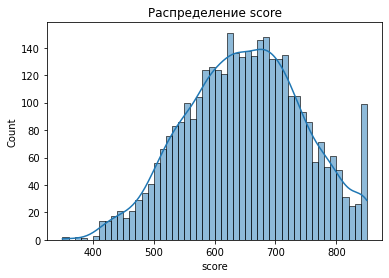

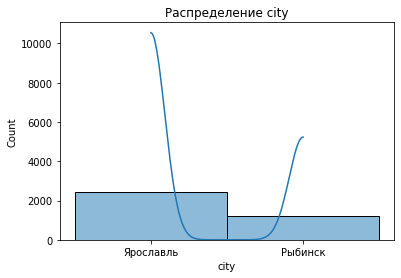

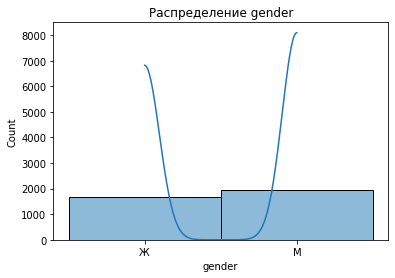

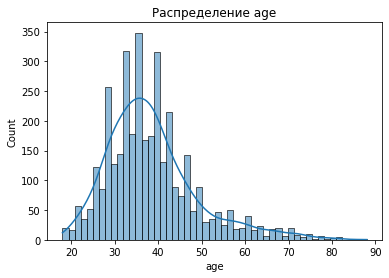

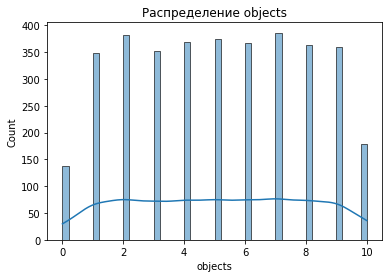

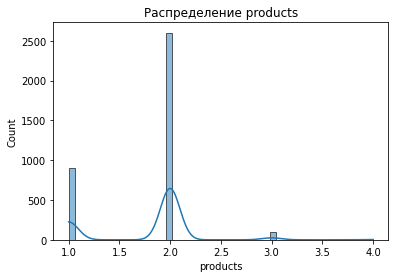

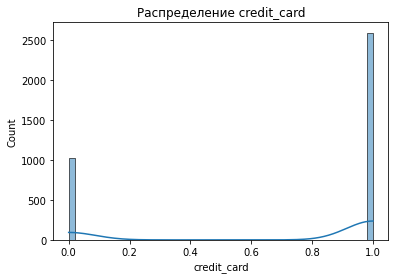

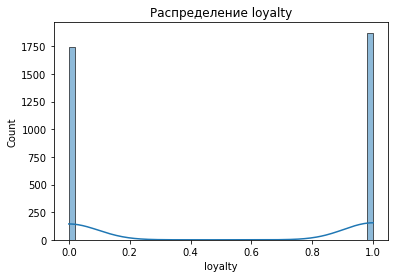

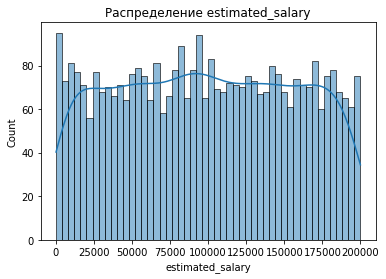

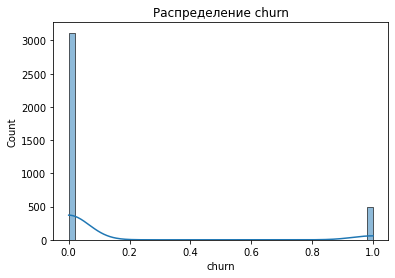

In [66]:
for i in df.drop(['user_id', 'balance'], axis=1).columns: 
    plt.title(f'Распределение {i}')
    sns.histplot(data=df[df['balance'].isna()][i], bins=50, kde=True)
    plt.show()

Видим что в Ростове Великом пропущенные значения отсутствуют. Возможно пропуски связаны с тем что банк предоставляет некий продукт который не требует открытия счета, а в Ростове данный продукт не предоставляют. Или пропуск означаент что счет был закрыт и на момент выгрузки данных действующих счетов у клиентов не было. Хорошего способа заполнить качественно эти пропуски не нахожу поэтому оставим пропущенные значения в данной графе. 

##  Исследовательский анализ данных

Изучим параметры: заработная плата клиента, баллы кредитного скоринга, город, возраст, количество объектов в собственности, количество продуктов, которыми пользуется клиент, наличие кредитной карты, активный клиент, ушёл или нет.

In [67]:
for i in df.drop(['user_id', 'score', 'balance', 'estimated_salary'], axis=1).columns:
    print(i)
    print(df[i].value_counts())
    print()

city
Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

gender
М    5457
Ж    4543
Name: gender, dtype: int64

age
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
88      1
82      1
85      1
83      1
Name: age, Length: 70, dtype: int64

objects
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: objects, dtype: int64

products
1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

credit_card
1    7055
0    2945
Name: credit_card, dtype: int64

loyalty
1    5151
0    4849
Name: loyalty, dtype: int64

churn
0    7963
1    2037
Name: churn, dtype: int64



Больше всего клиентов банка из Ярославля, между Ростовом Великим и Рыбинском разница в количестве клиентов небольшая, 2509 и 2477 соответственно. Среди клиентов больше мужчин, чем женщин на 914 человек, 5457 мужчин и 4543 женщин. Максимальное количество используемых продуктов составляет 4, наибольшее количество клиентов пользуется 1 или 2 продуктами. Более 70% клиентов имеют кредитную карту банка. Активными клиентами банка являются 51,5% клиентов. 20% клиентов из имеющих данных ушли из банка.

Построим гистограммы для распределения данных параметров 

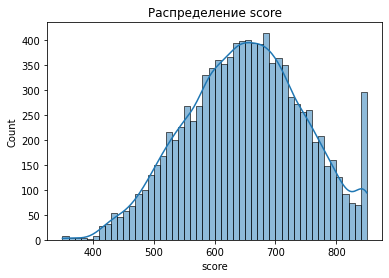

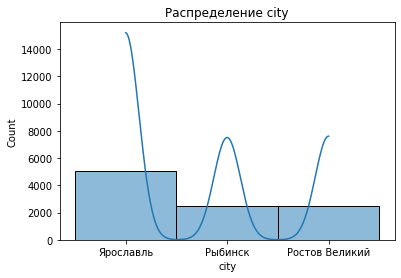

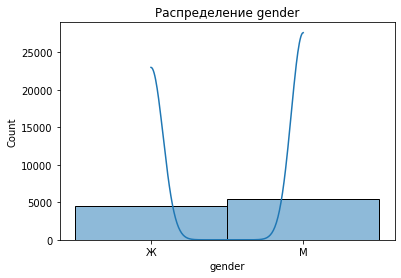

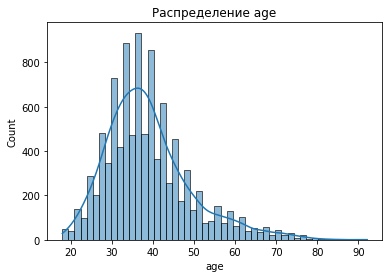

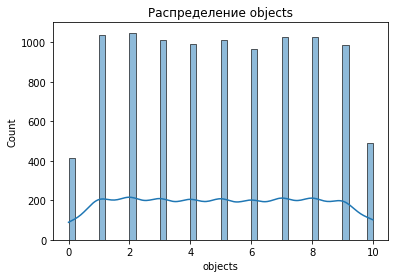

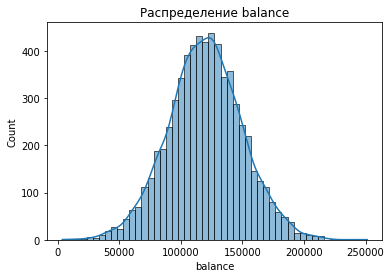

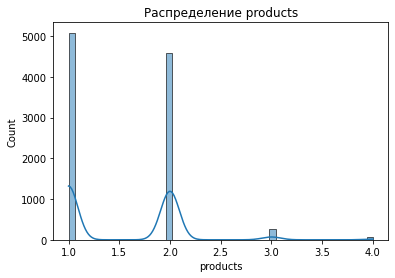

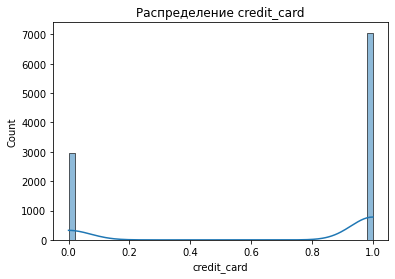

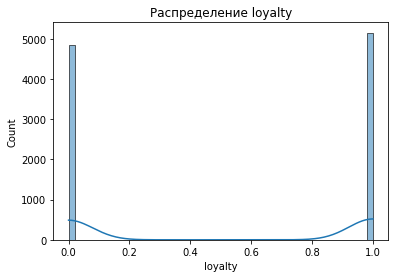

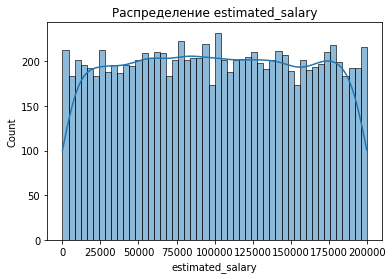

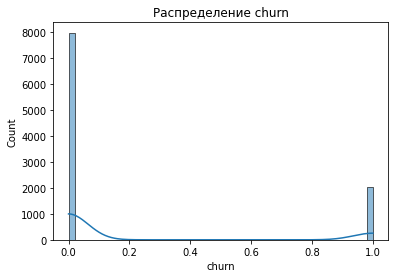

In [68]:
for i in df.drop('user_id', axis=1).columns: 
    plt.title(f'Распределение {i}')
    sns.histplot(data=df[i], bins=50, kde=True)
    plt.show()
    

Построим диаграммы размаха
 

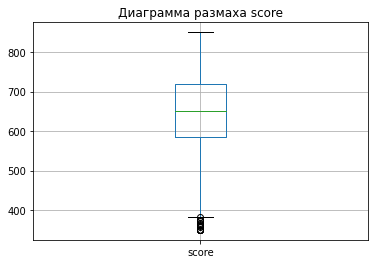

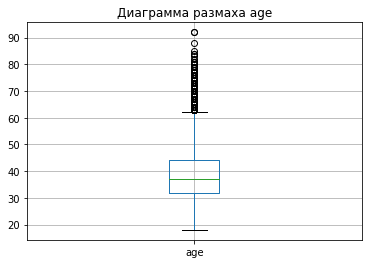

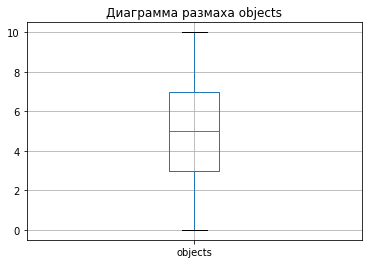

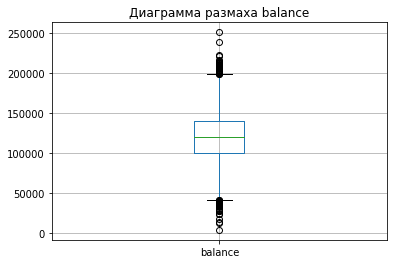

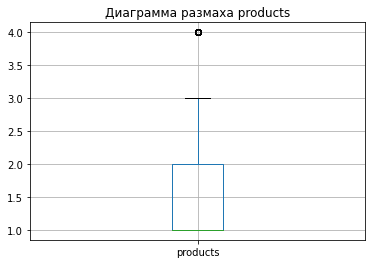

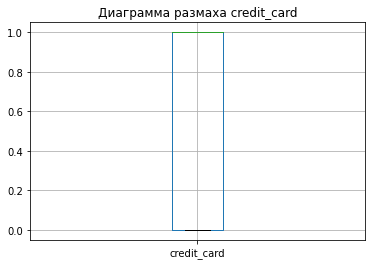

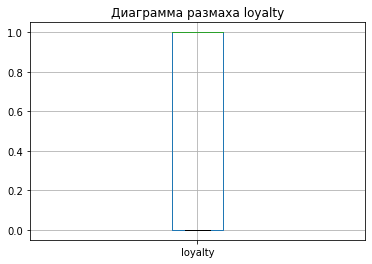

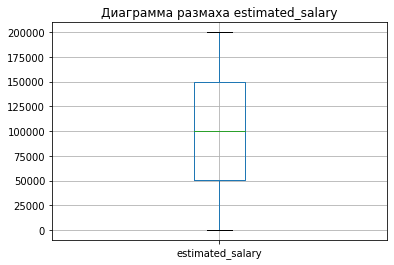

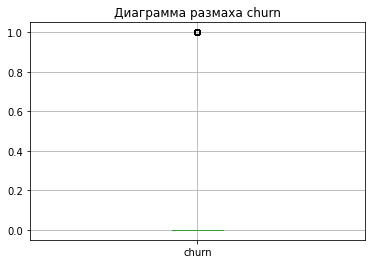

In [69]:
for i in df.drop(['user_id', 'city', 'gender'], axis=1).columns: 
    plt.title(f'Диаграмма размаха {i}')
    df.boxplot(i)
    plt.show()

Максимальное количество клиентов имеют значение баллов кредитного скоринга в районе от 650 до 690. Также около 300 клиентов имеют около 850 баллов кредитного скоринга. При этом по диаграмме размаха для данного поакзателя видно, что в данных присутствуют выбросы - значения менее 390 баллов. Так как про шкалу и систему оценки для баллов кредитного скоринга ничего не известно, то и оснований удалять эти выбросы нет.

Больше всего клиентов банка из Ярославля, а значения количества клиентов в Ростове Великом и Рыбинске на одном уровне. Среди клиентов больше мужчин чем женщин.

Наибольшее количество клиентов в возрасте от 32 до 43 лет. Распределение клиентов по возрасту иммеет "правый хвост", что подтверждается диаграммой размаха, клиентов страше 62 лет мало.

Распределение клиентов по количеству объектов в собственности близко к равномерному. При этом клиентов без объектов в собственности и с 10 объектами более чем в 2 раза меньше чем клиентов с количеством объектов от 1 до 9.

Баланс на счёте у наибольшего количетсва клиентов в диапазоне от 100000 до 140000.

Наибольшее количество клиентов пользуется 1 или 2 продуктами, совсем мало клиентов использующих 4 продукта. Более 4 продуктов клиенты не используют.

Количество клиентов имеющих кредитную карту банка более чем в 2 раза больше чем клиентов без кредитной карты банка.

Активных клиентов в банке на 3% больше чем неактивных.

Распределение количества клиентов по уровню заработной платы равномерное, количество клиентов изменяется от 175 до 225 при диапазоне в заработной плате от 0 до 200000.

Ушли из банка 20% клиентов.

Посмотрим на количество клиентов при группировке по количеству продуктов.

In [70]:
for i in ['city', 'gender', 'objects', 'credit_card', 'loyalty', 'churn']:
    display(df.pivot_table(index='products', columns=i, values='user_id', aggfunc='count'))

city,Ростов Великий,Рыбинск,Ярославль
products,,,
1,1349,1221,2514
2,1040,1183,2367
3,96,66,104
4,24,7,29


gender,Ж,М
products,,
1,2296,2788
2,2060,2530
3,149,117
4,38,22


objects,0,1,2,3,4,5,6,7,8,9,10
products,,,,,,,,,,,
1,236.0,568.0,473.0,529.0,504.0,501.0,490.0,517.0,525.0,500.0,241.0
2,171.0,431.0,543.0,430.0,462.0,468.0,456.0,482.0,468.0,451.0,228.0
3,6.0,32.0,21.0,42.0,20.0,36.0,17.0,24.0,28.0,23.0,17.0
4,NaN,4.0,11.0,8.0,3.0,7.0,4.0,5.0,4.0,10.0,4.0


credit_card,0,1
products,,
1,1506,3578
2,1344,3246
3,76,190
4,19,41


loyalty,0,1
products,,
1,2521,2563
2,2144,2446
3,153,113
4,31,29


churn,0,1
products,,
1,3675.0,1409.0
2,4242.0,348.0
3,46.0,220.0
4,NaN,60.0


Построим диаграмму, отражающую количество клиентов в зависимости от числа используемых продуктов.

In [71]:
df.pivot_table(index='products', values='user_id', aggfunc='count')

,user_id
products,
1,5084
2,4590
3,266
4,60


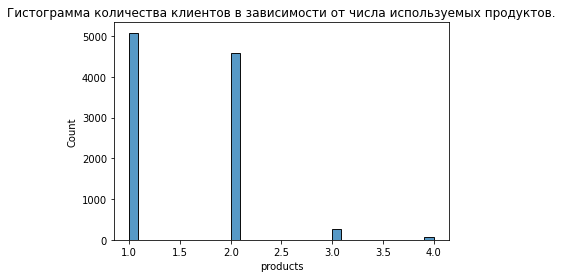

In [72]:
plt.title('Гистограмма количества клиентов в зависимости от числа используемых продуктов.')
sns.histplot(data= df['products']);

Наибольшее количество клиентов пользуется 1 или 2 продуктами, совсем мало клиентов использующих 3 и 4 продукта. Более 4 продуктов клиенты не используют.

Построим диаграмму, отражающую количество клиентов в зависимости от числа используемых продуктов по городам

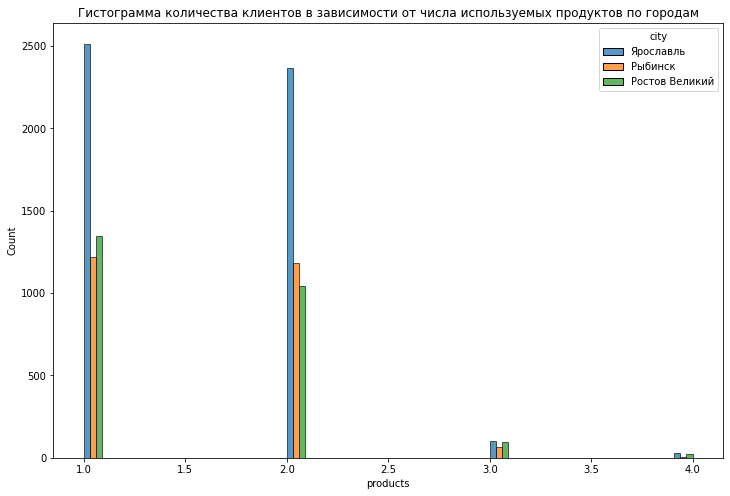

In [73]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма количества клиентов в зависимости от числа используемых продуктов по городам')
sns.histplot(data= df, x= 'products', hue='city', multiple="dodge" );

В всех городах преобладают клиенты использующие 1 или 2 продукта. 

Построим диаграмму, отражающую распределение заработной платы клиентов в зависимости от числа используемых продуктов.

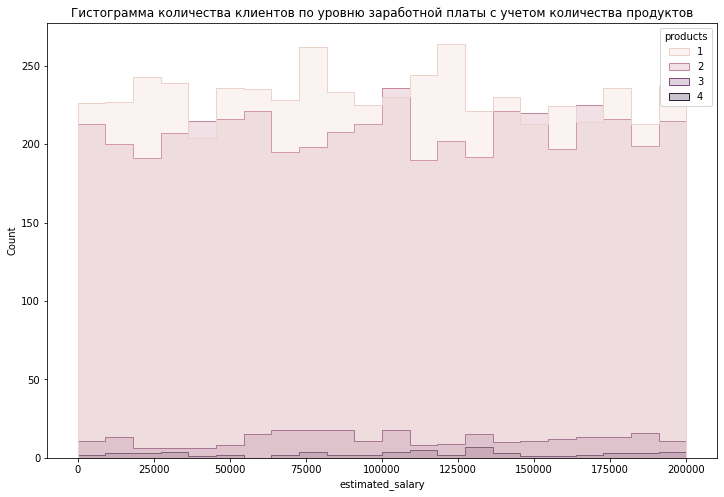

In [74]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма количества клиентов по уровню заработной платы с учетом количества продуктов')
sns.histplot(data=df, x= 'estimated_salary', hue='products', element="step");

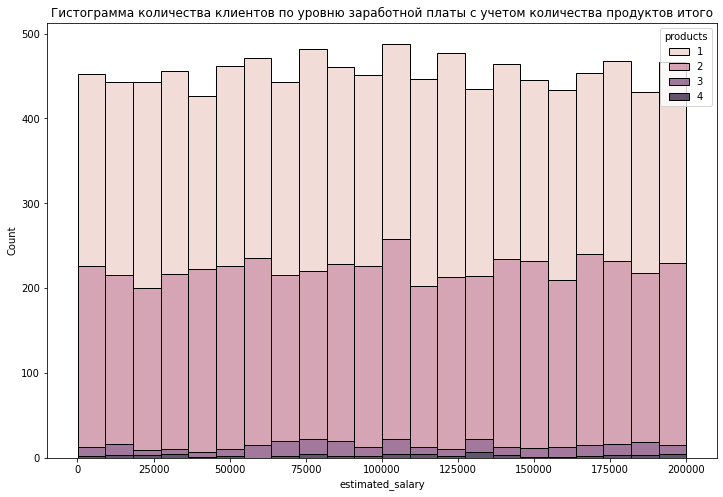

In [75]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма количества клиентов по уровню заработной платы с учетом количества продуктов итого')
sns.histplot(data=df, x= 'estimated_salary', hue='products', multiple="stack");

По графику видим что независимо от заработной платы чаще всего клиенты пользуются 1 или 2 продуктами. Распределение количества клиенттов по уровню заработной платы близко к равномерному. При диапазоне заработной платы от 0 до 200000 количество клиентов использующих 2 продукта изменяется в районе от 170 до 240, а клиентов использующих 1 продукт в районе от 205 до 260. Максимальное количество клиентов с заработной платой от 100000 до 110000. При этом 3 и более продуктами пользуется не более 25 человек независимо от уровня заработной платы.   

Построим диаграмму, отражающую распределение баллов кредитного скоринга в зависимости от числа используемых продуктов.

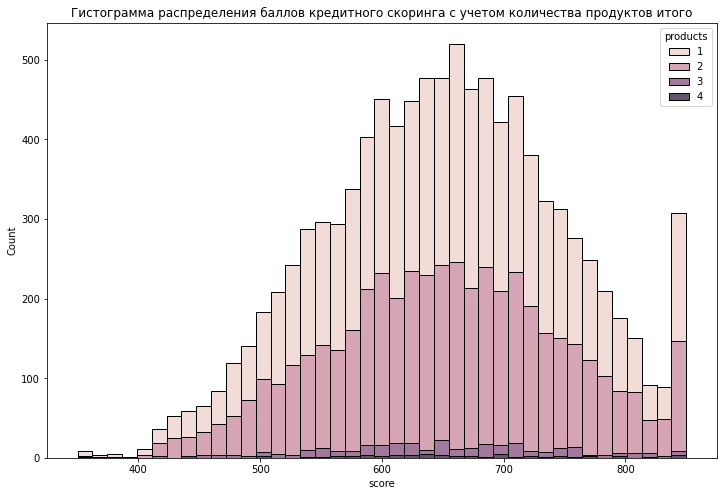

In [76]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма распределения баллов кредитного скоринга с учетом количества продуктов итого')
sns.histplot(data=df, x= 'score', hue='products', multiple="stack");

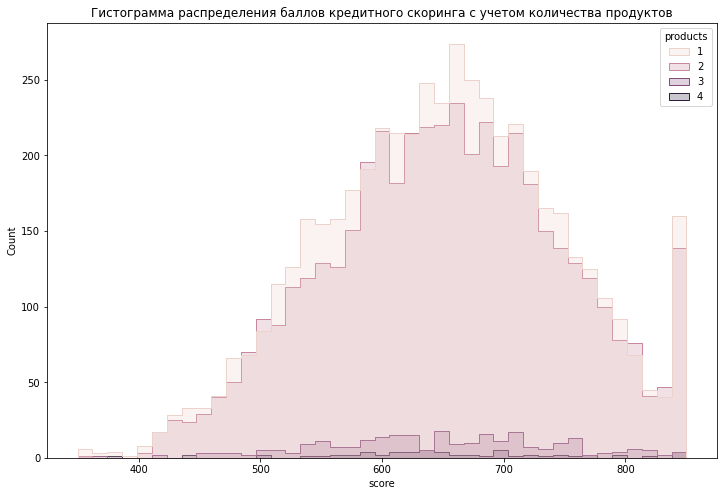

In [77]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма распределения баллов кредитного скоринга с учетом количества продуктов')
sns.histplot(data=df, x= 'score', hue='products', element="step");

По диаграммам видно что с количество клиентв использующих 1 продукт преобладает независимо от баллов кредитного скоринга.

Построим диаграмму, отражающую распределение возраста клиентов в зависимости от числа используемых продуктов.

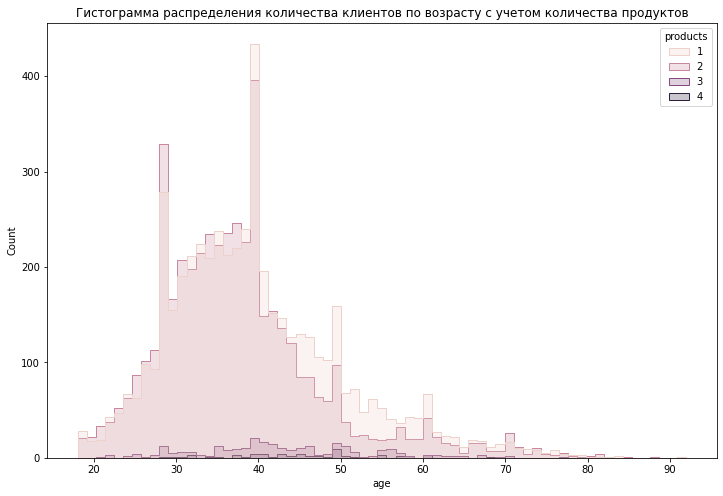

In [78]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма распределения количества клиентов по возрасту с учетом количества продуктов')
sns.histplot(data=df, x= 'age', hue='products', element="step");

По диаграмме видно что наибольшее количество клиетов в возрасте 27-28 лет и 38-39 лет. В возрасте от 18 до 40 преобладают клиенты использующие 2 продукта, а после 40 клиенты в основном используют 1 продукт.  

Построим диаграмму, отражающую распределение количества клиентов по количеству объектов в собственности в зависимости от числа используемых продуктов.

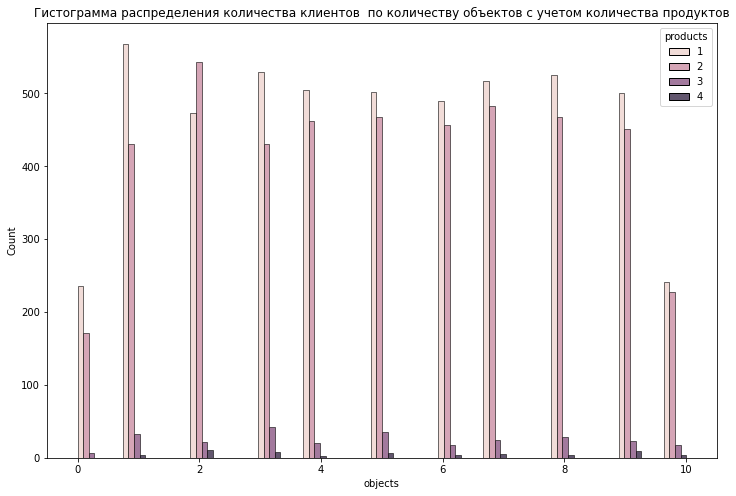

In [79]:
plt.figure(figsize=(12, 8))
plt.title('Гистограмма распределения количества клиентов  по количеству объектов с учетом количества продуктов')
sns.histplot(data=df, x= 'objects', hue='products', multiple="dodge");

По диаграмме видим, что только клиенты с 2 объектами собственности чаще пользуются 2 продуктами. при всех остальных вариантах количества объектов аренды наибоее популярно использование 1 продукта.

Построим графики зависимости заработной платы от возраста с учетом данных о наличии кредитной карты, количестве продуктов, городов и присутствия клиента (ушел или нет).   

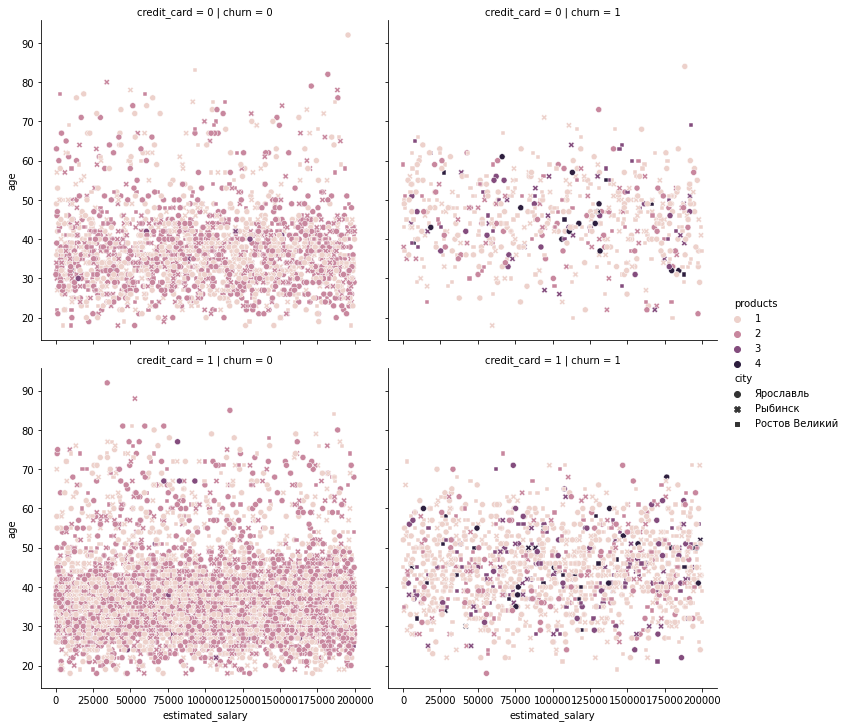

In [80]:
sns.relplot(kind='scatter', x="estimated_salary", y="age", data=df, hue="products", col="churn", row="credit_card", style="city")
plt.show()

Построим графики зависимости заработной платы от баллов кредитного скоринга с учетом данных о количестве объектов в собственности, количества продуктов, городов и присутствия клиента (ушел или нет).

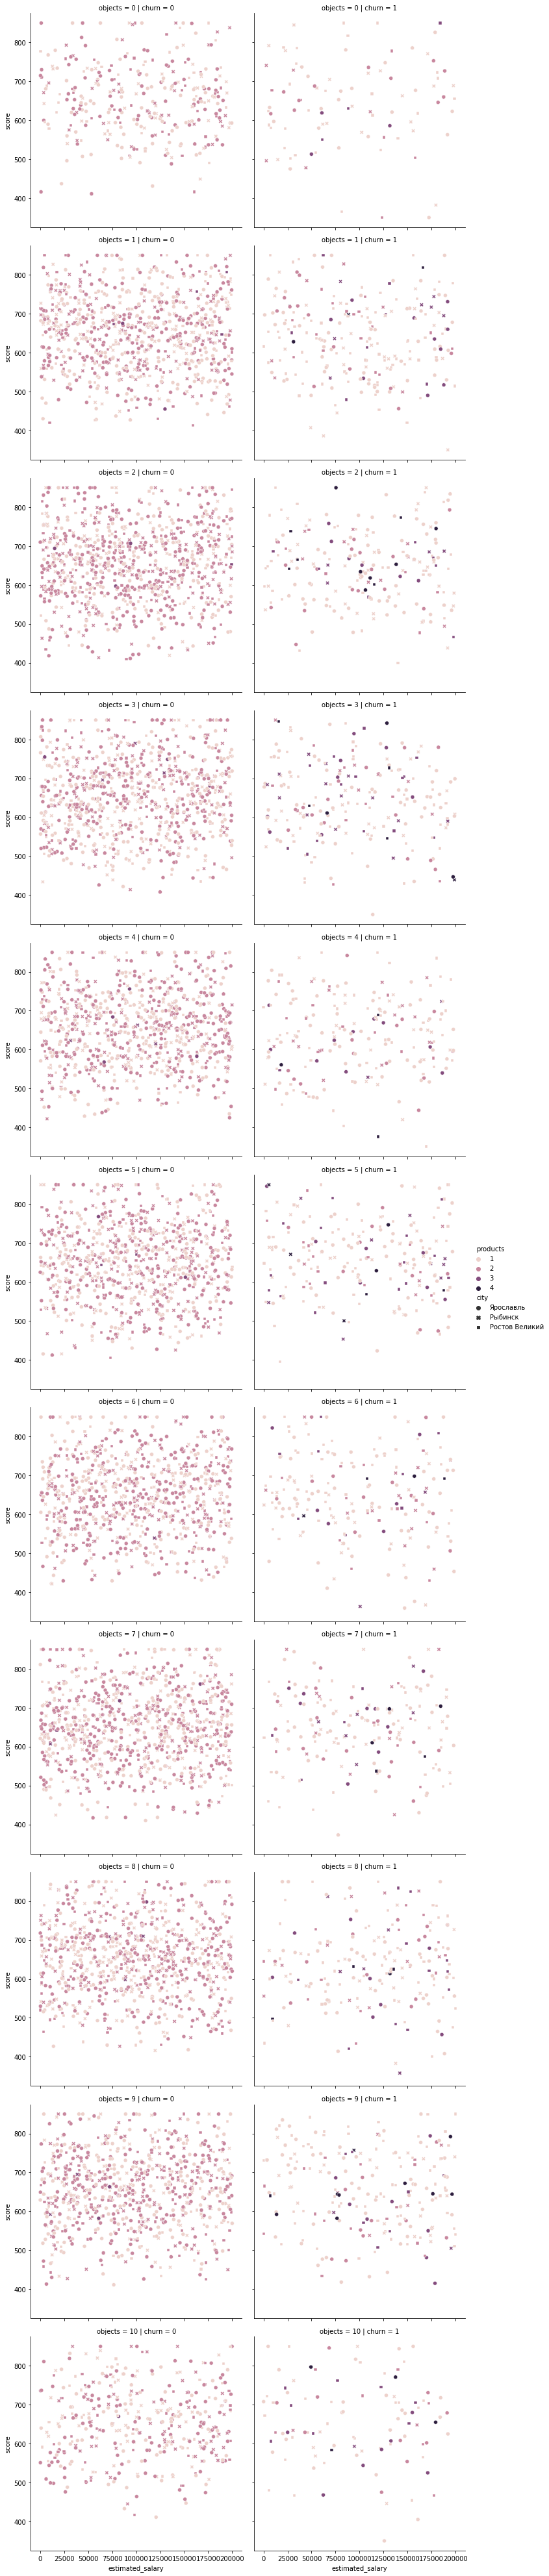

In [81]:
sns.relplot(kind='scatter', x="estimated_salary", y="score", data=df, hue="products", col="churn", row="objects", style="city")
plt.show()

По данным диаграммам  видно что в отток ушли все клиенты использующие 4 продукта независимо от города количесва объектов аренды и заработной платы. 

Проверим количество клиентов ушедших в отток с группировкой по количеству продуктов.

In [82]:
df.pivot_table(index='products', columns='churn', values='estimated_salary', aggfunc='count')

churn,0,1
products,,
1,3675.0,1409.0
2,4242.0,348.0
3,46.0,220.0
4,NaN,60.0


Посмотрим на корреляцию между параметрами. Для наглядности сделаем из таблицы корреляций хитмеп.

In [83]:
df.corr()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
user_id,1.000000,0.005308,0.009497,-0.014883,-0.008690,0.016972,-0.014025,0.001665,0.015271,-0.006248
score,0.005308,1.000000,-0.003965,0.000842,-0.004744,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.009497,-0.003965,1.000000,-0.009997,-0.012822,-0.030680,-0.011721,0.085472,-0.007201,0.285323
objects,-0.014883,0.000842,-0.009997,1.000000,0.005827,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,-0.008690,-0.004744,-0.012822,0.005827,1.000000,-0.001027,0.006721,-0.020418,-0.001856,0.017208
products,0.016972,0.012238,-0.030680,0.013444,-0.001027,1.000000,0.003183,0.009612,0.014204,-0.047820
credit_card,-0.014025,-0.005458,-0.011721,0.022583,0.006721,0.003183,1.000000,-0.011866,-0.009933,-0.007138
loyalty,0.001665,0.025651,0.085472,-0.028362,-0.020418,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,0.015271,-0.001384,-0.007201,0.007784,-0.001856,0.014204,-0.009933,-0.011421,1.000000,0.012097
churn,-0.006248,-0.027094,0.285323,-0.014001,0.017208,-0.047820,-0.007138,-0.156128,0.012097,1.000000


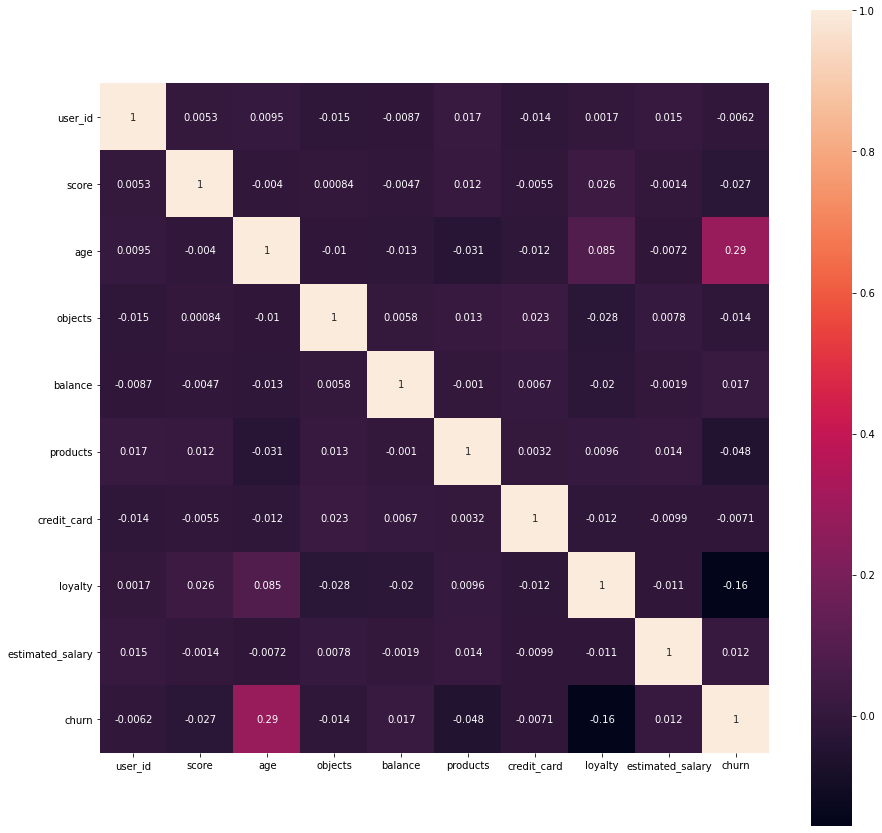

In [84]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), square = True, annot = True);

По таблице видно что между признаками нет сильной линейной корреляции. Максимальная корреляция между возрастом и уходом, с увеличением возраста больше коиентоы уходит.

## Сегментация клиентов

С учетом того что большинство клиентов используют 1 или 2 продукта, а все клиенты использующие 4 продукта ушли выделим 3 сегмента: 
- клиенты использующие 1 продукт
- клиенты использующие 2 продукта
- клиенты использующие более 2 продуктов

Для этого напишем функцию и с ее помощью добавим столбец group.

In [85]:
def group_products(products):
    if products == 1:
        return '1'
    elif products == 2:
        return '2'
    elif products > 2:
        return '>2'
    
group_products(3)  # проверим функцию   

'>2'

In [86]:
df['group'] = df['products'].apply(group_products) # добавляем столбец
df.head()      # выведем первые 5 строк

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,group
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,1
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,>2
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,2
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,1


Посмотрим на изменения признаков по выделенным сегментам.

In [87]:
for i in ['city', 'gender', 'objects', 'credit_card', 'loyalty', 'churn']:
    display(df.pivot_table(index='group', columns=i, values='user_id', aggfunc='count'))

city,Ростов Великий,Рыбинск,Ярославль
group,,,
1,1349,1221,2514
2,1040,1183,2367
>2,120,73,133


gender,Ж,М
group,,
1,2296,2788
2,2060,2530
>2,187,139


objects,0,1,2,3,4,5,6,7,8,9,10
group,,,,,,,,,,,
1,236,568,473,529,504,501,490,517,525,500,241
2,171,431,543,430,462,468,456,482,468,451,228
>2,6,36,32,50,23,43,21,29,32,33,21


credit_card,0,1
group,,
1,1506,3578
2,1344,3246
>2,95,231


loyalty,0,1
group,,
1,2521,2563
2,2144,2446
>2,184,142


churn,0,1
group,,
1,3675,1409
2,4242,348
>2,46,280


Визуализируем изменения параметров по сегментам.

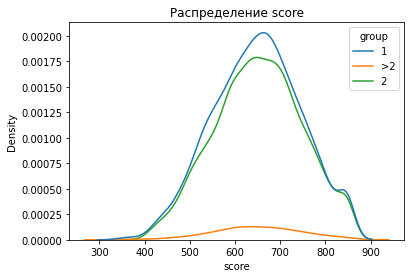

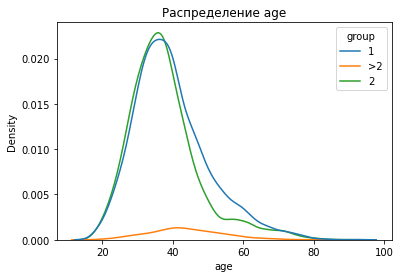

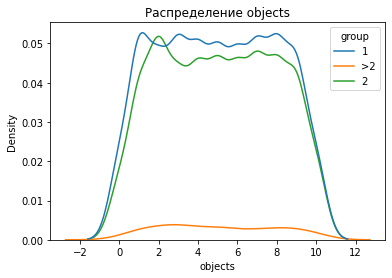

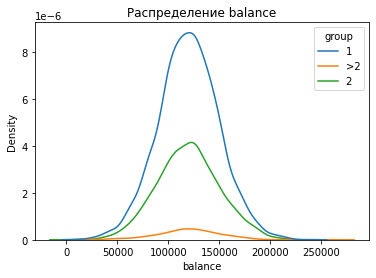

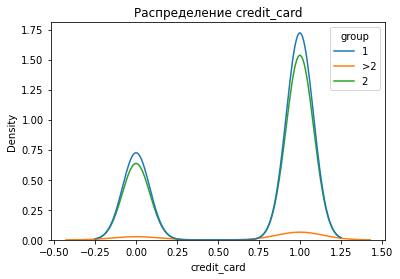

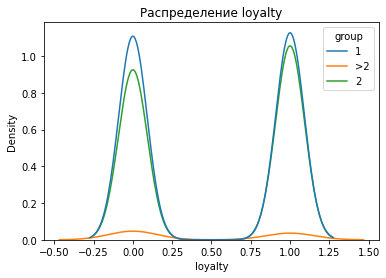

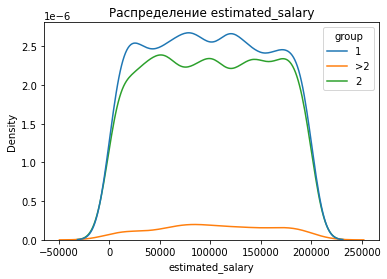

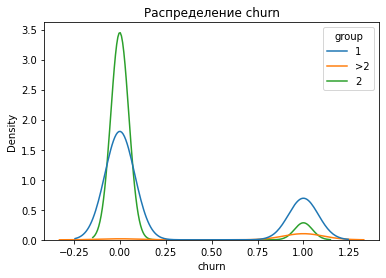

In [88]:
for i in df.drop(['user_id', 'city', 'gender', 'group', 'products'], axis=1).columns: 
    plt.title(f'Распределение {i}')
    sns.kdeplot(data=df, x=i, hue="group")
    plt.show()

Изменение признаков по сегментам подтвержает выводы сделанные при изучении данных по продуктам. Однако можно отметить следующие моменты.

Среди клиентов использующих более 2 продуктов больше клиентов ушло, чем осталось в отличии от сегментов с одним или двумя продуктами. Данный факт связан с тем что ушли все клиенты использовавшие 4 продукта, что было выявлено в ходе исследовательского анализа. 

Также среди клиентов использующих более 2 продуктов больше женщин, чем мужчин, в отличии от сегментов с одним или двумя продуктами. 

Среди клиентов пользующихся более чем 2 продуктами больше неактивных клиентов, чем активных, в отличие от двух других сегментов.

## Проверка гипотез

Необходимо проверить 2 гипотезы :

**Первая гипотеза**: Проверьте гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним. 

Сформулируем нулевую и альтернативную гипотезы. Н0 - средние заработные платы клиентов пользующихся одним продуктом и клиентов пользующихся двумя продуками равны. Н1 - средние заработные платы клиентов пользующихся одним продуктом и клиентов пользующихся двумя продуками не равны.

**Вторая гипотеза**: Среднее количество используемых продуктов в Ярославле совпадает со средним количеством используемых продуктов в других городах.

Сформулируем нулевую и альтернативную гипотезы. Н0 - среднее количество используемых продуктов в Ярославле равно среднему количеству используемых продуктов в других городах. Н1 - среднее количество используемых продуктов в Ярославле не равно среднему количеству используемых продуктов в других городах.

Так как генеральные совокупности не зависят друг от друга, размер выборок достаточно велик (более 4000 значений), а выборочные средние нормально распределены (Согласно центральной предельной теоремы, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности. Что верно даже если сама генеральная совокупность не распределена нормально.) используем t-test для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Уровень значимости примем равным 0,05.

Напишем функцию для проверки гипотез

In [89]:
def test_hypothes(alpha, sample1, sample2, equal_var):
    results = st.ttest_ind(sample1, sample2, equal_var=equal_var)
    print(results)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 

Проверка первой гипотезы

In [90]:
test_hypothes(0.05, df[df['group'] == '1']['estimated_salary'], df[df['group'] == '2']['estimated_salary'], False)

Ttest_indResult(statistic=-0.8227874662645565, pvalue=0.4106493940071987)
Не получилось отвергнуть нулевую гипотезу


Значение p-value высокое, значит нулевую гипотезу не отвергаем. Вероятность что средние заработные платы клиентов пользующихся одним продуктом и клиентов пользующихся двумя продуктами составляет 41%.

Проверка второй гипотезы

In [91]:
test_hypothes(0.05, df[df['city'] == 'Ярославль']['products'], df[df['city'] != 'Ярославль']['products'], False)

Ttest_indResult(statistic=0.12298197950516031, pvalue=0.9021238446942643)
Не получилось отвергнуть нулевую гипотезу


Значение p-value высокое, значит нулевую гипотезу не отвергаем. Вероятность что среднее количество используемых продуктов в Ярославле равно среднему количеству используемых продуктов в других городах составляет 90%.

## Общий вывод

В ходе проведенного анализа выявлено, что наибольшее количество клиентов пользуется 1 или 2 продуктами, совсем мало клиентов использующих 3 или 4 продукта. Более 4 продуктов клиенты не используют. Более 70% клиентов имеют кредитную карту банка. Активными клиентами банка являются 51,5% клиентов. 20% клиентов из имеющихся данных ушли из банка. Максимальное количество клиентов имеют значение баллов кредитного скоринга в районе от 650 до 690. 
Больше всего клиентов банка из Ярославля, а значения количества клиентов в Ростове Великом и Рыбинске близки друг к другу. Среди клиентов больше мужчин чем женщин.  Наибольшее количество клиентов в возрасте от 30 до 43 лет. Клиентов страше 62 лет значительно меньше. В возрасте от 18 до 40 преобладают клиенты использующие 2 продукта, а после 40 клиенты в основном используют 1 продукт.
Клиентов без объектов в собственности и с 10 объектами более чем в 2 раза меньше чем клиентов с количеством объектов от 1 до 9. Только клиенты с 2 объектами собственности чаще пользуются 2 продуктами. при всех остальных вариантах количества объектов аренды наибоее популярно использование 1 продукта.
Баланс на счёте у наибольшего количетсва клиентов в диапазоне от 100000 до 140000.
Независимо от заработной платы чаще всего клиенты пользуются 1 или 2 продуктами. При диапазоне заработной платы от 0 до 200000 количество клиентов использующих 2 продукта изменяется в районе от 170 до 240, а клиентов использующих 1 продукт в районе от 205 до 260. Максимальное количество клиентов с заработной платой от 100000 до 110000. При этом 3 и более продуктами пользуется не более 25 человек независимо от уровня заработной платы.
В отток ушли все клиенты использующие 4 продукта.
Выделино 3 сегмента клиентов:

- клиенты использующие 1 продукт
- клиенты использующие 2 продукта
- клиенты использующие более 2 продуктов.

К 1 сегменту относятся клиенты использующие 1 продукт, в остновном с 1 объектом в собственности или от 3 до 9, заработной платой от 0 до 200000, в большей степени мужчины, возраст клиентов в основном до 60 лет, с наличием кредитной карты, вравной степени активных и неактивных. Для привлечения клиентов к испоьзованию большего количества продуктов в данном сегменте можно обратить внимание на клиентов после 60 лет (возможно предпенсионные и пенсионные программы), так как у многих есть кредитные карты то стоит обратить внимание на развитие кредитных продуктов(авто, потребительское, ипотечное кредитование). Также стоит повышать активность пользования уже имеющимся продуктом банка, возможно улучшить условия или просто чаще напоминать о себе (пуш уведомления).

Ко 2 сегменту относятся клиенты использующие 2 продукта, больше клиентов с 2 объектами в собственности, заработной платой от 0 до 200000, в большей степени мужчины, возраст клиентов в основном до 52 лет, с наличием кредитной карты, больше активных, чем неактивных. клиентов с данного сегмента гораздо меньше уходит и больше остается. Для привлечения клиентов к испоьзованию большего количества продуктов в данном сегменте также можно обратить внимание на клиентов после 60 лет (возможно предпенсионные и пенсионные программы), так как у многих есть кредитные карты то стоит обратить внимание на развитие кредитных продуктов(авто, потребительское, ипотечное кредитование). 

К 3 сегменту относятся клиенты использующие более 2 продуктов, заработной платой от 0 до 200000, в большей степени женщины, возраст клиентов в основном до 52 лет, наличие кредитной карты у меньшего количества, больше активных, чем неактивных. клиентов с данного сегмента уходят. Для привлечения клиентов к использованию большего количества продуктов в данном сегменте также можно обратить внимание на клиентов после 60 лет (возможно предпенсионные и пенсионные программы, депозиты), привлечение клиентов к получению кредитных карт, услуги выгодной рассрочки. 

При выявлено что различия в средних заработных платах клиентов пользующихся одним продуктом и клиентов пользующихся двумя продуктами статистически не значимы. Среднее количество используемых продуктов не зависит от города проживания клиента.